In [15]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

from random import randint

In [16]:
protoFile = "pose_deploy_linevec.prototxt"
weightsFile = "pose_iter_440000.caffemodel"
nPoints = 18
# COCO Output Format
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16] ]

# index of pafs correspoding to the POSE_PAIRS
# e.g for POSE_PAIR(1,2), the PAFs are located at indices (31,32) of output, Similarly, (1,5) -> (39,40) and so on.
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], 
          [19,20], [21,22], [23,24], [25,26], [27,28], [29,30], 
          [47,48], [49,50], [53,54], [51,52], [55,56], 
          [37,38], [45,46]]

colors = [ [0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
         [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
         [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0]]

In [17]:
# Find the Keypoints using Non Maximum Suppression on the Confidence Map
def getKeypoints(probMap, threshold=0.1):
    
    mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)

    mapMask = np.uint8(mapSmooth>threshold)
    keypoints = []
    
    #find the blobs
    contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #for each blob find the maxima
    for cnt in contours:
        blobMask = np.zeros(mapMask.shape)
        blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
        maskedProbMap = mapSmooth * blobMask
        _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
        keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

    return keypoints

In [18]:
# Find valid connections between the different joints of a all persons present
def getValidPairs(output):
    valid_pairs = []
    invalid_pairs = []
    n_interp_samples = 10
    paf_score_th = 0.1
    conf_th = 0.7
    # loop for every POSE_PAIR
    for k in range(len(mapIdx)):
        # A->B constitute a limb
        pafA = output[0, mapIdx[k][0], :, :]
        pafB = output[0, mapIdx[k][1], :, :]
        pafA = cv2.resize(pafA, (frameWidth, frameHeight))
        pafB = cv2.resize(pafB, (frameWidth, frameHeight))

        # Find the keypoints for the first and second limb
        candA = detected_keypoints[POSE_PAIRS[k][0]]
        candB = detected_keypoints[POSE_PAIRS[k][1]]
        nA = len(candA)
        nB = len(candB)

        # If keypoints for the joint-pair is detected
        # check every joint in candA with every joint in candB 
        # Calculate the distance vector between the two joints
        # Find the PAF values at a set of interpolated points between the joints
        # Use the above formula to compute a score to mark the connection valid
        
        if( nA != 0 and nB != 0):
            valid_pair = np.zeros((0,3))
            for i in range(nA):
                max_j=-1
                maxScore = -1
                found = 0
                for j in range(nB):
                    # Find d_ij
                    d_ij = np.subtract(candB[j][:2], candA[i][:2])
                    norm = np.linalg.norm(d_ij)
                    if norm:
                        d_ij = d_ij / norm
                    else:
                        continue
                    # Find p(u)
                    interp_coord = list(zip(np.linspace(candA[i][0], candB[j][0], num=n_interp_samples),
                                            np.linspace(candA[i][1], candB[j][1], num=n_interp_samples)))
                    # Find L(p(u))
                    paf_interp = []
                    for k in range(len(interp_coord)):
                        paf_interp.append([pafA[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))],
                                           pafB[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))] ]) 
                    # Find E
                    paf_scores = np.dot(paf_interp, d_ij)
                    avg_paf_score = sum(paf_scores)/len(paf_scores)
                    
                    # Check if the connection is valid
                    # If the fraction of interpolated vectors aligned with PAF is higher then threshold -> Valid Pair  
                    if ( len(np.where(paf_scores > paf_score_th)[0]) / n_interp_samples ) > conf_th :
                        if avg_paf_score > maxScore:
                            max_j = j
                            maxScore = avg_paf_score
                            found = 1
                # Append the connection to the list
                if found:            
                    valid_pair = np.append(valid_pair, [[candA[i][3], candB[max_j][3], maxScore]], axis=0)

            # Append the detected connections to the global list
            valid_pairs.append(valid_pair)
        else: # If no keypoints are detected
            print("No Connection : k = {}".format(k))
            invalid_pairs.append(k)
            valid_pairs.append([])
    print(valid_pairs)
    return valid_pairs, invalid_pairs

In [19]:
# This function creates a list of keypoints belonging to each person
# For each detected valid pair, it assigns the joint(s) to a person
# It finds the person and index at which the joint should be added. This can be done since we have an id for each joint
def getPersonwiseKeypoints(valid_pairs, invalid_pairs):
    # the last number in each row is the overall score 
    personwiseKeypoints = -1 * np.ones((0, 19))

    for k in range(len(mapIdx)):
        if k not in invalid_pairs:
            partAs = valid_pairs[k][:,0]
            partBs = valid_pairs[k][:,1]
            indexA, indexB = np.array(POSE_PAIRS[k])

            for i in range(len(valid_pairs[k])): 
                found = 0
                person_idx = -1
                for j in range(len(personwiseKeypoints)):
                    if personwiseKeypoints[j][indexA] == partAs[i]:
                        person_idx = j
                        found = 1
                        break

                if found:
                    personwiseKeypoints[person_idx][indexB] = partBs[i]
                    personwiseKeypoints[person_idx][-1] += keypoints_list[partBs[i].astype(int), 2] + valid_pairs[k][i][2]

                # if find no partA in the subset, create a new subset
                elif not found and k < 17:
                    row = -1 * np.ones(19)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    # add the keypoint_scores for the two keypoints and the paf_score 
                    row[-1] = sum(keypoints_list[valid_pairs[k][i,:2].astype(int), 2]) + valid_pairs[k][i][2]
                    personwiseKeypoints = np.vstack([personwiseKeypoints, row])
    return personwiseKeypoints

In [20]:
image1 = cv2.imread("grp3.jpg")
frameWidth = image1.shape[1]
frameHeight = image1.shape[0]

In [21]:
t = time.time()
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

# if device == "cpu":
#     net.setPreferableBackend(cv2.dnn.DNN_TARGET_CPU)
#     print("Using CPU device")
# elif device == "gpu":
#     net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
#     net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
#     print("Using GPU device")

# Fix the input Height and get the width according to the Aspect Ratio
inHeight = 368
inWidth = int((inHeight/frameHeight)*frameWidth)

inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)
output = net.forward()
print("Time Taken = {}".format(time.time() - t))

Time Taken = 3.02567982673645


(-0.5, 1599.5, 1154.5, -0.5)

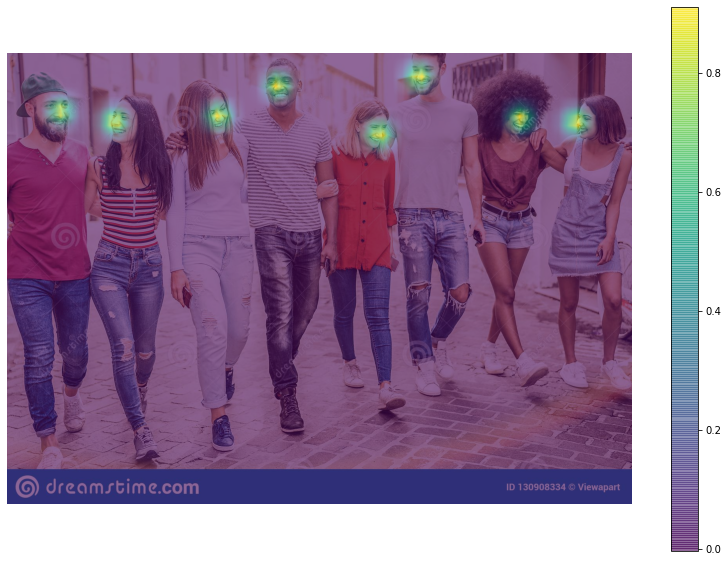

In [22]:
i = 0
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (frameWidth, frameHeight))
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off")

In [23]:
detected_keypoints = []
keypoints_list = np.zeros((0,3))
keypoint_id = 0
threshold = 0.1

for part in range(nPoints):
    probMap = output[0,part,:,:]
    probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
#     plt.figure()
#     plt.imshow(255*np.uint8(probMap>threshold))
    keypoints = getKeypoints(probMap, threshold)
    print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
    keypoints_with_id = []
    for i in range(len(keypoints)):
        keypoints_with_id.append(keypoints[i] + (keypoint_id,))
        keypoints_list = np.vstack([keypoints_list, keypoints[i]])
        keypoint_id += 1

    detected_keypoints.append(keypoints_with_id)

Keypoints - Nose : [(961, 213, 0.86033934), (1462, 187, 0.88445336), (286, 187, 0.76716363), (1312, 163, 0.8888651), (537, 163, 0.90209156), (137, 161, 0.79840803), (687, 87, 0.9108812), (1061, 62, 0.89620304)]
Keypoints - Neck : [(312, 287, 0.74138963), (888, 263, 0.82847816), (112, 263, 0.8223195), (1512, 239, 0.79946834), (512, 262, 0.7202638), (1286, 238, 0.79312414), (711, 188, 0.83096105), (1087, 162, 0.814011)]
Keypoints - R-Sho : [(237, 288, 0.6688752), (0, 263, 0.7587677), (837, 263, 0.78608507), (437, 263, 0.7236789), (1437, 238, 0.88353634), (1211, 237, 0.67887664), (612, 188, 0.79084074), (1011, 162, 0.74198014)]
Keypoints - R-Elb : [(188, 389, 0.20807032), (412, 413, 0.6597928), (1187, 338, 0.13216509), (812, 364, 0.4002469), (1412, 315, 0.20940425), (962, 288, 0.15096825)]
Keypoints - R-Wr : [(437, 540, 0.7005229), (836, 488, 0.23890933), (1188, 439, 0.20955212), (0, 439, 0.19265436), (1386, 238, 0.15379249)]
Keypoints - L-Sho : [(387, 264, 0.65101254), (1562, 263, 0.8938

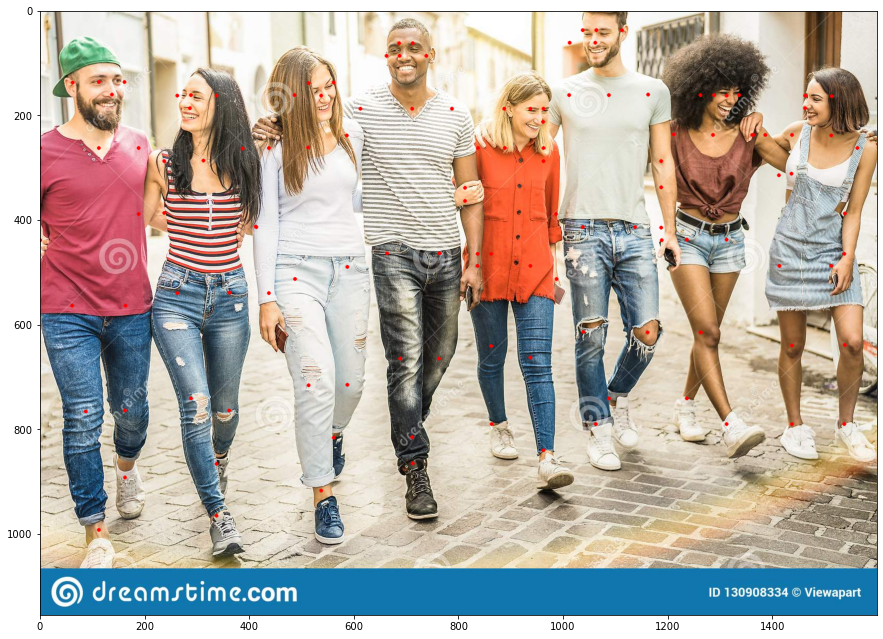

In [24]:
frameClone = image1.copy()
for i in range(nPoints):
    for j in range(len(detected_keypoints[i])):
        cv2.circle(frameClone, detected_keypoints[i][j][0:2], 3, [0,0,255], -1, cv2.LINE_AA)
plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])

In [25]:
valid_pairs, invalid_pairs = getValidPairs(output)

[array([[ 8.        , 16.        ,  0.90645909],
       [ 9.        , 18.        ,  0.96096196],
       [10.        , 17.        ,  0.9017909 ],
       [11.        , 20.        ,  0.89143514],
       [12.        , 19.        ,  0.89067444],
       [13.        , 21.        ,  0.95194032],
       [14.        , 22.        ,  0.95000424],
       [15.        , 23.        ,  0.96874118]]), array([[ 8.        , 35.        ,  0.70980819],
       [ 9.        , 38.        ,  0.96770221],
       [10.        , 37.        ,  0.96367662],
       [11.        , 36.        ,  0.76428232],
       [12.        , 39.        ,  0.72121907],
       [13.        , 40.        ,  1.008529  ],
       [14.        , 41.        ,  0.87936336],
       [15.        , 42.        ,  0.95571185]]), array([[16.        , 24.        ,  0.26713934],
       [18.        , 27.        ,  0.57535886],
       [19.        , 25.        ,  0.71891338],
       [20.        , 28.        ,  0.41647634],
       [21.        , 26.        ,  

In [26]:
personwiseKeypoints = getPersonwiseKeypoints(valid_pairs, invalid_pairs)

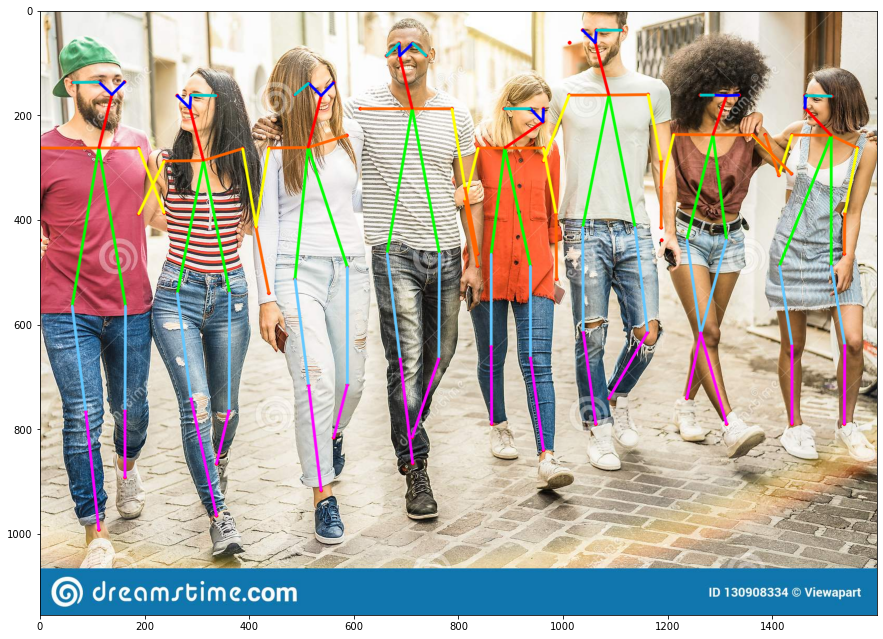

In [27]:
for i in range(17):
    for n in range(len(personwiseKeypoints)):
        index = personwiseKeypoints[n][np.array(POSE_PAIRS[i])]
        if -1 in index:
            continue
        B = np.int32(keypoints_list[index.astype(int), 0])
        A = np.int32(keypoints_list[index.astype(int), 1])
        cv2.line(frameClone, (B[0], A[0]), (B[1], A[1]), colors[i], 3, cv2.LINE_AA)
        
plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])

# For real camera

In [31]:
cap=cv2.VideoCapture(0)
cap.set(3,1920)
cap.set(4,1080)

def rescale_frame(frame, percent=75):
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation =cv2.INTER_AREA)


if not cap.isOpened():
    cap=cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("cannot opened")
while cv2.waitKey(1)<0:
    hasFrame,frame=cap.read()
    if not hasFrame:
        cv2.waitKey()
        break
    
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0] 
    t = time.time()
    net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)
    inHeight = 368
    inWidth = int((inHeight/frameHeight)*frameWidth)

    inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

    net.setInput(inpBlob)
    output = net.forward()
    
   
    detected_keypoints = []
    keypoints_list = np.zeros((0,3))
    keypoint_id = 0
    threshold = 0.1

    for part in range(nPoints): 
        probMap = output[0,part,:,:]
        probMap = cv2.resize(probMap, (frame.shape[1], frame.shape[0]))
#     plt.figure()
#     plt.imshow(255*np.uint8(probMap>threshold))
        keypoints = getKeypoints(probMap, threshold)
#         print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
        keypoints_with_id = []
        for i in range(len(keypoints)):
            keypoints_with_id.append(keypoints[i] + (keypoint_id,))
            keypoints_list = np.vstack([keypoints_list, keypoints[i]])
            keypoint_id += 1
        detected_keypoints.append(keypoints_with_id)
        
    valid_pairs, invalid_pairs = getValidPairs(output)
        
    personwiseKeypoints = getPersonwiseKeypoints(valid_pairs, invalid_pairs)
        
    frameClone = frame.copy()
    for i in range(17):
         for n in range(len(personwiseKeypoints)):
                index = personwiseKeypoints[n][np.array(POSE_PAIRS[i])]
                if -1 in index:
                    continue
                B = np.int32(keypoints_list[index.astype(int), 0])
                A = np.int32(keypoints_list[index.astype(int), 1])
                cv2.line(frameClone, (B[0], A[0]), (B[1], A[1]), colors[i], 3, cv2.LINE_AA)
        
#     plt.figure(figsize=[15,15])
#     cv2.imshow(frameClone)
        
#     t, _ = net.getPerfProfile()
#     freq = cv2.getTickFrequency() / 1000
#     cv2.putText(frame, '%.2fms' % (t / freq), (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    frame75 = rescale_frame(frameClone, percent=60)
    cv2.imshow('frame75', frame75)
    #cv2.imshow('OpenPose using OpenCV', frameClone)   
    if cv2.waitKey(10) & 0xFF==ord('q'):
        break       
cap.release()
cv2.destroyAllWindows()       
    
    

No Connection : k = 2
No Connection : k = 3
No Connection : k = 4
No Connection : k = 5
No Connection : k = 7
No Connection : k = 8
No Connection : k = 9
No Connection : k = 10
No Connection : k = 11
[array([], shape=(0, 3), dtype=float64), array([], shape=(0, 3), dtype=float64), [], [], [], [], array([[1.        , 5.        , 0.16219688]]), [], [], [], [], [], array([], shape=(0, 3), dtype=float64), array([[0.        , 6.        , 0.93615173]]), array([[6.       , 8.       , 0.6694444]]), array([[0.        , 7.        , 0.88482367]]), array([[7.        , 9.        , 0.81138156]]), array([], shape=(0, 3), dtype=float64), array([], shape=(0, 3), dtype=float64)]
No Connection : k = 2
No Connection : k = 3
No Connection : k = 4
No Connection : k = 5
No Connection : k = 6
No Connection : k = 7
No Connection : k = 8
No Connection : k = 9
No Connection : k = 10
No Connection : k = 16
No Connection : k = 17
[array([], shape=(0, 3), dtype=float64), array([[1.        , 3.        , 0.41454959]])

# For videoes

In [32]:
cap=cv2.VideoCapture("football.mp4")
hasFrame, frame = cap.read()

vid_writer = cv2.VideoWriter('output.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame.shape[1],frame.shape[0]))

net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)
def rescale_frame(frame, percent=75):
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation =cv2.INTER_AREA)


while cv2.waitKey(1) < 0:
    t = time.time()
    hasFrame, frame = cap.read()
    frameCopy = np.copy(frame)
    if not hasFrame:
        cv2.waitKey()
        break
    
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    inHeight = 368
    inWidth = int((inHeight/frameHeight)*frameWidth)
    
    inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                              (0, 0, 0), swapRB=False, crop=False)
    net.setInput(inpBlob)
    output = net.forward()
    detected_keypoints = []
    keypoints_list = np.zeros((0,3))
    keypoint_id = 0
    threshold = 0.1

    for part in range(nPoints): 
        probMap = output[0,part,:,:]
        probMap = cv2.resize(probMap, (frame.shape[1], frame.shape[0]))
#     plt.figure()
#     plt.imshow(255*np.uint8(probMap>threshold))
        keypoints = getKeypoints(probMap, threshold)
#         print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
        keypoints_with_id = []
        for i in range(len(keypoints)):
            keypoints_with_id.append(keypoints[i] + (keypoint_id,))
            keypoints_list = np.vstack([keypoints_list, keypoints[i]])
            keypoint_id += 1
        detected_keypoints.append(keypoints_with_id)
        
    valid_pairs, invalid_pairs = getValidPairs(output)
        
    personwiseKeypoints = getPersonwiseKeypoints(valid_pairs, invalid_pairs)
        
#     frameClone = frame.copy()
    for i in range(17):
         for n in range(len(personwiseKeypoints)):
                index = personwiseKeypoints[n][np.array(POSE_PAIRS[i])]
                if -1 in index:
                    continue
                B = np.int32(keypoints_list[index.astype(int), 0])
                A = np.int32(keypoints_list[index.astype(int), 1])
                cv2.line(frameCopy, (B[0], A[0]), (B[1], A[1]), colors[i], 3, cv2.LINE_AA)
        
#     plt.figure(figsize=[15,15])
#     cv2.imshow(frameClone)
        
#     t, _ = net.getPerfProfile()
#     freq = cv2.getTickFrequency() / 1000
#     cv2.putText(frame, '%.2fms' % (t / freq), (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    frame75 = rescale_frame(frameCopy, percent=40)
    cv2.imshow('frame75', frame75)
    #cv2.imshow('OpenPose using OpenCV', frameCopy)
    vid_writer.write(frameCopy)
    if cv2.waitKey(10) & 0xFF==ord('q'):
        break       
cap.release()
cv2.destroyAllWindows()       
    
    


No Connection : k = 14
No Connection : k = 18
[array([[1.        , 3.        , 0.57838345],
       [2.        , 4.        , 0.65470617]]), array([[1.        , 7.        , 0.57641625],
       [2.        , 8.        , 0.72126432]]), array([[4.        , 5.        , 0.56448191]]), array([[5.        , 6.        , 0.63194775]]), array([[ 7.        ,  9.        ,  0.77143943],
       [ 8.        , 10.        ,  0.90390942]]), array([[ 9.        , 11.        ,  0.8226685 ],
       [10.        , 12.        ,  0.90371386]]), array([[ 1.        , 13.        ,  0.72028121],
       [ 2.        , 14.        ,  0.68294206]]), array([[13.        , 15.        ,  0.68191998],
       [14.        , 16.        ,  0.82547433]]), array([[15.        , 17.        ,  0.81395846],
       [16.        , 18.        ,  0.93358608]]), array([[ 1.        , 19.        ,  0.70528635],
       [ 2.        , 20.        ,  0.65565396]]), array([[19.        , 21.        ,  0.66134593],
       [20.        , 22.        ,  0.85